In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math

print(tf.__version__)


2.15.0


In [2]:
base_dir = "./archive"

train_cat_path = os.path.join(base_dir, "training_set", "training_set", "cats")
test_cat_path = os.path.join(base_dir, "test_set", "test_set", "cats")
train_dog_path = os.path.join(base_dir, "training_set", "training_set", "dogs")
test_dog_path = os.path.join(base_dir, "test_set", "test_set", "dogs")

In [3]:
def read_image_set(path, gray_scale = False, target_shape = (200, 200)):
    animals = []
    
    filenames = os.listdir(path)
    for file in tqdm(filenames):
        current_img = plt.imread(os.path.join(path, file))
        current_img = cv2.resize(current_img, target_shape)
        # Convert to grayscale
        if gray_scale:
            current_img = cv2.cvtColor(current_img, cv2.COLOR_RGB2GRAY)
        animals.append(current_img)
    return animals

In [4]:
print(f"Reading cat images...")
cats = read_image_set(train_cat_path, gray_scale = False)

print(f"Reading dog images...")
dogs = read_image_set(train_dog_path, gray_scale = False)

Reading cat images...


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 332.87it/s]


Reading dog images...


100%|█████████████████████████████████████████████████████████████████████████████| 4005/4005 [00:13<00:00, 291.96it/s]


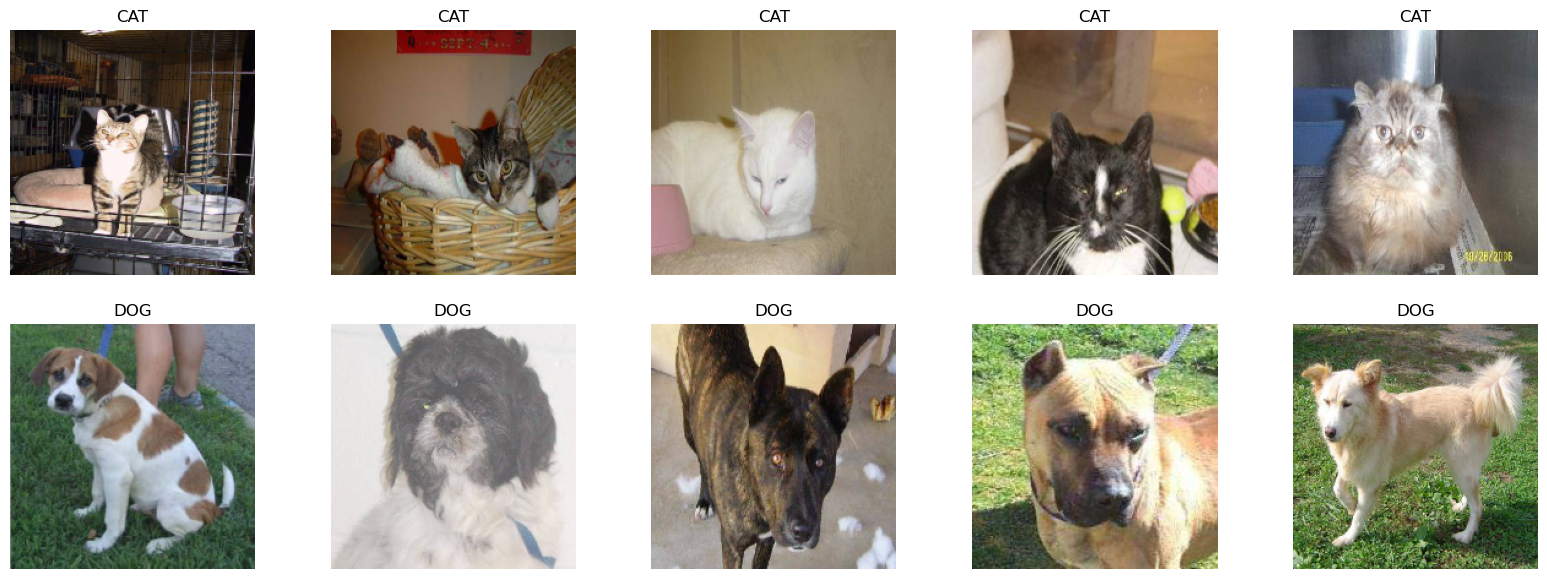

In [5]:
#Print random "good" cats and dogs
num_images = 5
_, axes = plt.subplots(2, num_images, figsize=(20, 7))

for i in range(num_images):
    axes[0, i].imshow(cats[random.randint(0, len(cats)-1)])
    axes[0, i].axis("off")
    axes[0, i].set_title("CAT")
    
    axes[1, i].imshow(dogs[random.randint(0, len(dogs)-1)])
    axes[1, i].axis("off")
    axes[1, i].set_title("DOG")
    
plt.show()

In [6]:
#Create the training set
from sklearn.model_selection import train_test_split

training = cats + dogs
# Create training labels for softmax predictions
num_cats = len(cats)
num_dogs = len(dogs)
training_labels = np.array([[0, 1] for _ in range(num_cats)] + [[1, 0] for _ in range(num_dogs)])


train_data, val_data, train_labels, val_labels = train_test_split(training, training_labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = np.array(train_data), np.array(val_data), np.array(train_labels), np.array(val_labels)
if training[0].shape[-1] != 3: # checks if the images are in greyscale
    train_data = tf.expand_dims(train_data, axis=-1)
    val_data = tf.expand_dims(val_data, axis=-1)

print(f"Size of train data {train_data.shape}, size of labels {train_labels.shape}")
print(f"Size of validation data {val_data.shape}, size of labels {val_labels.shape}")

images_shape = train_data[0].shape

Size of train data (6404, 200, 200, 3), size of labels (6404, 2)
Size of validation data (1601, 200, 200, 3), size of labels (1601, 2)


In [23]:
# Create network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, AveragePooling2D, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=images_shape))
model.add(BatchNormalization())

model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(8, (3, 3), activation='relu', kernel_regularizer = 'l2'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((4, 4)))

model.add(Conv2D(4, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate = 1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_13 (Ba  (None, 198, 198, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_78 (Conv2D)          (None, 196, 196, 8)       2312      
                                                                 
 conv2d_79 (Conv2D)          (None, 194, 194, 32)      2336      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 97, 97, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_80 (Conv2D)          (None, 95, 95, 8)       

In [24]:
# Train network
tf.random.set_seed(2023)
history = model.fit(
    x = train_data,
    y = train_labels,
    batch_size = 32,
    epochs = 20,
    validation_data = (val_data, val_labels)
)

Epoch 1/20
201/201 [==============================] - 174s 846ms/step - loss: 0.7398 - accuracy: 0.5306 - val_loss: 0.7029 - val_accuracy: 0.5122
Epoch 2/20
201/201 [==============================] - 190s 946ms/step - loss: 0.6772 - accuracy: 0.6037 - val_loss: 0.6512 - val_accuracy: 0.6346
Epoch 3/20
201/201 [==============================] - 194s 967ms/step - loss: 0.6490 - accuracy: 0.6348 - val_loss: 0.6275 - val_accuracy: 0.6615
Epoch 4/20
201/201 [==============================] - 198s 986ms/step - loss: 0.6257 - accuracy: 0.6655 - val_loss: 0.6033 - val_accuracy: 0.6871
Epoch 5/20
201/201 [==============================] - 199s 991ms/step - loss: 0.6056 - accuracy: 0.6846 - val_loss: 0.6012 - val_accuracy: 0.6827
Epoch 6/20
201/201 [==============================] - 198s 987ms/step - loss: 0.5873 - accuracy: 0.7024 - val_loss: 0.5854 - val_accuracy: 0.6958
Epoch 7/20
201/201 [==============================] - 203s 1s/step - loss: 0.5838 - accuracy: 0.7036 - val_loss: 0.5920 - va

KeyboardInterrupt: 

In [ ]:
# Evaluate
print(f"Reading cat images...")
test_cats = read_image_set(test_cat_path, gray_scale = True)

print(f"Reading dog images...")
test_dogs = read_image_set(test_dog_path, gray_scale = True)

test = np.array(test_cats + test_dogs)
num_cats = len(test_cats)
num_dogs = len(test_dogs)
test_labels = np.array([[0, 1] for _ in range(num_cats)] + [[1, 0] for _ in range(num_dogs)])

model.predict()




In [ ]:
# Test the pretrained ResNet model using transfer learning

resNet = tf.keras.applications.ResNet50(weights = 'imagenet',
                        include_top = False,
                        input_shape = (200,200, 3))

resNet.trainable = False # Freeze layers
resNet_model = Sequential([
        resNet,
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dropout(0.4),
        Dense(2, activation = 'softmax')])
resNet_model.compile(optimizer=Adam(learning_rate = 1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
resNet_model.summary()

In [ ]:
# Train network
history2 = resNet_model.fit(
    x = train_data,
    y = train_labels,
    batch_size = 32,
    epochs = 20,
    validation_data = (val_data, val_labels)
)